# Adversarial Machine Learning in Network Intrusion Detection Systems

L'article utilise comme dataset NSL-KDD et UNSW-NB15, qui représentent des flux de données réseau bruts. Ces flux sont un mélange de différents types de trafic, mais également un mélange de bonnes et malicieuses données. Le but étant d'altérer ces paquets réseau pour pouvoir déjouer les systèmes de detection d'intrusion, tout en gardant les flux de données fonctionnels. 

In [57]:
import os
import pandas as pd


df = pd.read_csv("KDDTest+.csv")
#df.info()

In [58]:
df2 = pd.read_csv("UNSW_NB15_training-set.csv")
#df2.info()

# Genetic Algorithm

Le *Genetic algorithm* (GA) est un algorithme qui se base sur la génétique et la sélection naturelle. Le GA utilise une forme de données appelées chromosome : ces données (vecteurs) sont formées et les valeurs de différentes features sont destinées à évoluer comme pour un gêne d'être vivant.
Certaines *features* sont inchangeable du à leur importance dans le bon fonctionnement des paquets.

- En premier lieu, on va créer une population de 100 chromosomes, dont leurs données seront générer aléatoirement, séparées en 2 parties, les données que l'ont peu modifier et les autres. (pour les opérations qui suivent, on va utiliser la partie que l'on peut modifier)
- on va ensuite utiliser l'opération de *cross over*. On choisi aléatoirement 2 chromosomes que l'on va séparer l'un de 25% de ses features et donc, de l'autre des 75% autres, que l'on va échanger pour créer 2 nouveau chromosomes. Ces nouveaux chromosomes seront ensuite insérés dans la population.
- Enfin, on va utiliser l'opération de *mutation* sur la partie que l'on peut modifier, qui consiste à choisir de manière aléatoire un chromosome et de même pour une de ses features. Toute cette opération est exécutée 
- On regroupe les 2 parties des chromosomes.
- Finalement, on va utiliser une *fitness function* pour évaluer chaque chromosome, s'ils sont bénins (seuil à 99,99%) ou non. On retiendra le meilleur chromosome toutes les 5 générations.
- On répète tout ce processus 100 fois
On obtient alors un nouveau dataset ne contenant que des vecteurs "malsains" qui seront testés dans la partie expérience.

In [59]:
#!pip install geneticalgorithm

In [60]:
import sklearn
import numpy as np
import random
from random import randint
from geneticalgorithm import geneticalgorithm as ga
from sklearn import svm
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder

#Creation of initial population
listProtocols = ["tcp","udp","icmp"]
listData = ["private","ftp_data","eco_i","telnet","http","smtp","imap4","systat","pop3","domain_u","whois","netbios_dgm"]
listSF = ["SF","S0","REJ","RSTR"]
#cell 3 = 62825648 - 0
# 24 à 30 et 33 à 40 entre 0 et 1
# 4 à 23 , 31- 32,  entre 0 et 20
#derniere = 0 - 21

# creation of artifical dataset
def initialPopulation(df, nbChrom):
    initPopulation = []
    for i in range (nbChrom):
        chrom = []
        for j in range (len(df.columns)):
            if(j == 0) :
                chrom.insert(j,random.randint(0, 2))
            if(j == 1) :
                chrom.insert(j,random.randint(0, 11))
            if(j == 2) :
                chrom.insert(j,randint(0, 62825648))
            if((j >= 24 and j <= 30) or (j >= 33 and j <= 40)) :
                chrom.insert(j,random.uniform(0, 1))
            if((j >= 4 and j <= 23) or j == 32 or j ==33) :
                chrom.insert(j,random.randint(0, 62825648))
            if(j == 41) :
                chrom.insert(j,random.randint(0,21))
        initPopulation.append(chrom)
    return initPopulation




dimDF = len(df.columns)
dimDF2 = len(df2.columns)

#We have to reduce to a minimum data size otherwise our computers can not run the fit after...
dfCopy = df.copy()
dfCopy = dfCopy.head(1000)

# preparation of the data : transforming string input to int 
LE = LabelEncoder()
dfCopy['protocol_type'] = LE.fit_transform(dfCopy['protocol_type'])
dfCopy['service'] = LE.fit_transform(dfCopy['service'])
dfCopy['flag'] = LE.fit_transform(dfCopy['flag'])
dfCopy['class'] = LE.fit_transform(dfCopy['class'])
dfCopy.head()

y = dfCopy['class']
dfCopy.drop(['class'], axis='columns', inplace=True)
X = dfCopy



In [61]:
population = initialPopulation(dfCopy,100)
#fitnessScore(population,)
#population

In [62]:
#Parameters given in the section 4.3 of the article
svm = svm.SVC(C = 220, gamma = 0.01, probability = True, tol = 0.001)
#  decision trees
dectr = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 4, \
                                    min_samples_leaf = 2, max_depth = 20, min_impurity_decrease = 0.1)
#naive bayes
nb = GaussianNB()
#k nearest neighbors
knn = KNeighborsClassifier(n_neighbors = 3, algorithm ='auto')

estimators = [ ('svm', svm), ('dt', dectr), ('nb', nb), ('knn', knn)]
model = ensemble.VotingClassifier(estimators, voting='hard')

fitModel = model.fit(X,y)


# https://datascienceplus.com/genetic-algorithm-in-machine-learning-using-python/

def fitnessScore(population,yTest):
    scores = []
    for chromosome in population :
        prediction = fitModel.predict(chromosome)
        # We want the bad pred to be valued better
        # 0 correspond to "anomaly" and 1 to "normal"
        if(prediction == 0):
            score = 1
        else :
            score = 0
        scores.append(score)
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)
    return list(scores[inds][::-1]), list(population[inds,:][::-1])

''' # TO ADAPT
def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen

def crossover(pop_after_sel):
    population_nextgen=pop_after_sel
    for i in range(len(pop_after_sel)):
        child=pop_after_sel[i]
        child[3:7]=pop_after_sel[(i+1)%len(pop_after_sel)][3:7]
        population_nextgen.append(child)
    return population_nextgen

def mutation(pop_after_cross,mutation_rate):
    population_nextgen = []
    for i in range(0,len(pop_after_cross)):
        chromosome = pop_after_cross[i]
        for j in range(len(chromosome)):
            if random.random() < mutation_rate:
                chromosome[j]= not chromosome[j]
        population_nextgen.append(chromosome)
    #print(population_nextgen)
    return population_nextgen

def generations(size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                   X_test, y_train, y_test):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        print(scores[:2])
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score
'''

' # TO ADAPT\ndef selection(pop_after_fit,n_parents):\n    population_nextgen = []\n    for i in range(n_parents):\n        population_nextgen.append(pop_after_fit[i])\n    return population_nextgen\n\ndef crossover(pop_after_sel):\n    population_nextgen=pop_after_sel\n    for i in range(len(pop_after_sel)):\n        child=pop_after_sel[i]\n        child[3:7]=pop_after_sel[(i+1)%len(pop_after_sel)][3:7]\n        population_nextgen.append(child)\n    return population_nextgen\n\ndef mutation(pop_after_cross,mutation_rate):\n    population_nextgen = []\n    for i in range(0,len(pop_after_cross)):\n        chromosome = pop_after_cross[i]\n        for j in range(len(chromosome)):\n            if random.random() < mutation_rate:\n                chromosome[j]= not chromosome[j]\n        population_nextgen.append(chromosome)\n    #print(population_nextgen)\n    return population_nextgen\n\ndef generations(size,n_feat,n_parents,mutation_rate,n_gen,X_train,\n                                  

Le but est de maximiser le nombre de vecteurs malsain classés en sain.

# Particle Swarn Optimization

L'idée du *Particle Swarm Optimization* est que pour chaque particule d'une nuée, on va essayer de trouver la meilleure position retournée par la *fitness function*. 

- D'abord, on doit créer la nuée de 200 particules. Les particules sont formées à partir d'une rangée du dataset et d'une partie généré aléatoirement, toujours avec les mêmes *features* que le dataset. Comme que pour le GA, on devrait prendre seulement la partie mutable des particules à modifier. Ensuites, pour chaque particules est attribué une vélocité de 0.7.
- Pour chaque itération, on va évaluer chaque particule à partir de la *fitness function*. On met à jour la meilleur valeur de la fonction fitness possible de chaque particules (de 0.5 au départ) et de la meilleur valeur de la fonction fitness global (de 0.4 au départ)
- On calcule en suite la distance entre la position de chaque particule et on récupère la meilleure valeur grâce à la fonction de fitness. On met à jour la vélocité et la position de chaque particule avec les valeurs précédentes.
- On répète tout ce processus 100 fois au maximum ou s'il y a une amélioration de moins de 0.001%.
La nué de particules devient alors un nouveau dataset de vecteurs *malsains*

In [63]:
#!pip install pyswarms

In [64]:
from pyswarms.single import GlobalBestPSO
from pyswarms.utils.search.grid_search  import SearchBase

from sklearn.ensemble import VotingClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

def prepare_UNSW_NB15(data):
    LE = LabelEncoder()
    copy = data[data['label']==1]
    copy = copy.drop(['label'], axis=1)
    copy['proto'] = LE.fit_transform(copy['proto'])
    copy['service'] = LE.fit_transform(copy['service'])
    copy['state'] = LE.fit_transform(copy['state'])
    copy['attack_cat'] = LE.fit_transform(copy['attack_cat'])
    return copy

def voting_classifier(X_train, Y_train) :
  sv = svm.SVC(gamma = 0.01, C = 220.0, tol = 0.01, probability = True)
  dt = DecisionTreeClassifier(
      criterion = "entropy", min_samples_split = 4, min_samples_leaf = 2, max_depth = 20, min_impurity_decrease = 0.1)
  nb = GaussianNB()
  kn = KNeighborsClassifier( n_neighbors = 3, algorithm = "auto")

  vC = VotingClassifier (estimators=
                         [('svm', sv), ('dt', dt), ('nb', nb), ('knn',kn)], voting='soft')
  vC = vC.fit(X_train,Y_train)
  return vC

def Pso (dim, data) :
  option = {'c1': 0.5, 'c2': 0.4, 'w' : 0.7}
  opt = GlobalBestPSO (n_particles=200, dimensions=dim, options=option)
  return opt.optimize(prepare_UNSW_NB15, 100, None, True, data)

In [65]:
#from sklearn.model_selection import train_test_split

#df2prepare = Pso (len(copy.columns), df2)

#X_train, X_test, y_train, y_test = train_test_split(df2prepare, test_size=0.2, random_state=300)

#voting_classifier(X_train, y_train)

# Generative Adversarial Network

Le *Generative Adversial Network* est une technique de deep learning qui va confronter deux réseaux de neuronnes. Ces deux réseaux de neuronnes correspondent l'un à la génération des vecteur *malicieux* et donc à ceux qu'elles permettent de tromper, l'autre est le discriminateur, qui lui va essayer de deviner si l'entrée est saine ou non.
Comme les méthodes précédentes, on va modifier d'abord la partie modifiable, c'est à dire non fixée des vecteurs. 
- Pour le générateur, on va sélectionner aléatoirement un vecteur "malsain". On va ajouter du bruit dans certaines des features choisies au hasard, toujours dans la partie modifiable du vecteur malicieux. Puis ce vecteur va rentrer dans le réseau neuronal du générateur avec comme sortie, un vecteur de la taille de la partie mutable du vecteur d'entrée. On recombine le vecteur de sortie avec la partie non changeable du vecteur de l'entrée, et on le donne en entrée du discriminateur. Les labels sortant de ce dernier permettrons d'améliorer le réseau de neurone du générateur.
- Pour le discriminateur, on va faire la même chose avec mais un vecteur bénin.
- Les deux réseaux de neurones utiliserons des sets de données d'entraînements.



# EXPERIENCE

Les expériences sont enfin réalisée sur les 11 modèles de classification en utilisant les sets produits précédemment. 
L'article ne mentionne pas les hyperparamètres à appliquer pour les 11 classifieurs. 
Les 11 classifieurs sont Support Vector Machine (SVM), Decision Trees (DT), Naive Bayes (NB), k Nearest Neighbors (KNN), Random Forest (RF), Multi-layer Perceptron (MLP), Gradient Boosting (GB), Logistic Regression (LR), Linear Discriminant Analysis (LDA), Quadratic Discriminant Analysis (QDA), and Bagging (BAG)
Nous laisserons principalement les paramètres par défaut pour réaliser les expériences.
Les résultats attendus pour ces expériences sont un taux élevé de mauvaise classification (dans le cas où nous arriverions à générer les adversairal datasets). 


In [66]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from numpy import mean,std
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [67]:
def prepare_UNSW_NB15(df):
    dfcopy = df.copy()
    dfcopy = df.sample(n = 10000)
    LE = LabelEncoder()
    #label = dfcopy.loc[:,('label')]
    #dfcopy = dfcopy.drop(['label'], axis=1)
    dfcopy['proto'] = LE.fit_transform(dfcopy['proto'])
    dfcopy['service'] = LE.fit_transform(dfcopy['service'])
    dfcopy['state'] = LE.fit_transform(dfcopy['state'])
    dfcopy['attack_cat'] = LE.fit_transform(dfcopy['attack_cat'])
    dfcopy['label'] = LE.fit_transform(dfcopy['label'])
    
    y = dfcopy['label']
    dfcopy.drop(['label'], axis='columns', inplace=True)
    return dfcopy, y

In [68]:
def prepareKDD(df):
    trainCopy = df.copy()
    # limit cause we can't run it on 22000 entries.
    trainCopy = df.sample(n = 10000)

    # preparation of the data : transforming string input to int 
    LE = LabelEncoder()
    trainCopy['protocol_type'] = LE.fit_transform(trainCopy['protocol_type'])
    trainCopy['service'] = LE.fit_transform(trainCopy['service'])
    trainCopy['flag'] = LE.fit_transform(trainCopy['flag'])
    trainCopy['class'] = LE.fit_transform(trainCopy['class'])
    
    y = trainCopy['class']
    trainCopy.drop(['class'], axis='columns', inplace=True)
    
    return trainCopy, y

In [69]:
def classifier(clf, X_train, Y_train, X_test, Y_test):
    model = clf();
    model.fit(X_train, Y_train);
    msKDD = missClassifiedAsNormalKDD(Y_test, X_test, model)
    msUNSW = missClassifiedAsNormalUNSW(Y_test, X_test, model)
    return model.score(X_test, Y_test), msKDD, msUNSW

In [70]:
def comparaison (clf, X_train, Y_train, X_test, Y_test) :
    scores = []
    scoresMsKDD = []
    scoresMsUNSW = []
    for i in clf :
        score, msKDD, msUNSW = classifier(i, X_train, Y_train, X_test, Y_test)
        scores.append(score)
        scoresMsKDD.append(msKDD)
        scoresMsUNSW.append(msUNSW)
    return scores, scoresMsKDD, scoresMsUNSW

In [71]:
def baggingexp(X_train, y_train, X_test, y_test):
    
    model = BaggingClassifier(base_estimator=None, n_estimators=10, random_state=0).fit(X_train, y_train)
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#     n_scores = cross_val_score(model, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

    #missClassifiedAsNormalUNSW(y_test, X_test, model)
    msKDD = missClassifiedAsNormalKDD(y_test, X_test, model)
    msUNSW = missClassifiedAsNormalUNSW(y_test, X_test, model)
    return model.score(X_test, y_test), msKDD, msUNSW

In [72]:
def SVMc(X_train, y_train, X_test, y_test):
    model = SVC()
    model.fit(X_train,y_train)
    msKDD = missClassifiedAsNormalKDD(y_test, X_test, model)
    msUNSW = missClassifiedAsNormalUNSW(y_test, X_test, model)
    return model.score(X_test, y_test), msKDD, msUNSW

In [73]:
def QDA(X_train, y_train, X_test, y_test):
    model = QuadraticDiscriminantAnalysis()
    model.fit(X_train, y_train)
    msKDD = missClassifiedAsNormalKDD(y_test, X_test, model)
    msUNSW = missClassifiedAsNormalUNSW(y_test, X_test, model)
    return model.score(X_test, y_test), msKDD, msUNSW

In [74]:
def LDA(X_train, y_train, X_test, y_test):
    model = LinearDiscriminantAnalysis()
    model.fit(X_train, y_train)
    msKDD = missClassifiedAsNormalKDD(y_test, X_test, model)
    msUNSW = missClassifiedAsNormalUNSW(y_test, X_test, model)
    return model.score(X_test, y_test), msKDD, msUNSW

In [75]:
def logisticRegression(X_train, y_train, X_test, y_test):
    model = LogisticRegression(random_state=0)
    model.fit(X_train, y_train)
    msKDD = missClassifiedAsNormalKDD(y_test, X_test, model)
    msUNSW = missClassifiedAsNormalUNSW(y_test, X_test, model)
    return model.score(X_test, y_test), msKDD, msUNSW

In [76]:
def gradBoost(X_train, y_train, X_test, y_test):
    model = GradientBoostingClassifier(random_state=0)
    model.fit(X_train, y_train)
    msKDD = missClassifiedAsNormalKDD(y_test, X_test, model)
    msUNSW = missClassifiedAsNormalUNSW(y_test, X_test, model)
    return model.score(X_test, y_test), msKDD, msUNSW

In [77]:
def MLP(X_train, y_train, X_test, y_test):
    model = MLPClassifier(random_state=0, max_iter=10)
    model.fit(X_train, y_train)
    msKDD = missClassifiedAsNormalKDD(y_test, X_test, model)
    msUNSW = missClassifiedAsNormalUNSW(y_test, X_test, model)
    return model.score(X_test, y_test), msKDD, msUNSW

In [78]:
def randomForest(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(max_depth=2, random_state=0)
    model.fit(X_train, y_train)
    msKDD = missClassifiedAsNormalKDD(y_test, X_test, model)
    msUNSW = missClassifiedAsNormalUNSW(y_test, X_test, model)
    return model.score(X_test, y_test), msKDD, msUNSW

In [79]:
def plotClassifieurBarScoreMissclassified(score):
    classifieur = []
    for i in range (len(score)):
        score[i] = (1 - score[i])*100
    plotDF = pd.DataFrame({'Classifieur':clfName, 'Score':score})
    plotDF.plot.bar(x="Classifieur", y='Score', rot=0,figsize=(16,5))

def plotClassifieurBarScore(score):
    classifieur = []
    for i in range (len(score)):
        score[i] = score[i]*100
    plotDF = pd.DataFrame({'Classifieur':clfName, 'Score':score})
    plotDF.plot.bar(x="Classifieur", y='Score', rot=0,figsize=(16,5))

In [80]:
# retrieve the global score, and the missclassied score for both datasets 
def all_classifier_score(X_train, X_test, y_train, y_test) :
    clf = [DecisionTreeClassifier, GaussianNB, KNeighborsClassifier]
    clfName = ["DTC", "GaussianNB", "KNC"]
    scores, scoresMsKDD, scoresMsUNSW = comparaison(clf, X_train, y_train, X_test, y_test)
    
    score, msKDD, msUNSW = SVMc(X_train,y_train, X_test, y_test)
    scores.append(score)
    scoresMsKDD.append(msKDD)
    scoresMsUNSW.append(msUNSW)
    clfName.append("SVMc")
    
    score, msKDD, msUNSW = baggingexp(X_train,y_train, X_test, y_test)
    scores.append(score)
    scoresMsKDD.append(msKDD)
    scoresMsUNSW.append(msUNSW)
    clfName.append("Bagging")
    
    score, msKDD, msUNSW = QDA(X_train,y_train, X_test, y_test)
    scores.append(score)
    scoresMsKDD.append(msKDD)
    scoresMsUNSW.append(msUNSW)
    clfName.append("QDA")
    
    score, msKDD, msUNSW = logisticRegression(X_train,y_train, X_test, y_test)
    scores.append(score)
    scoresMsKDD.append(msKDD)
    scoresMsUNSW.append(msUNSW)
    clfName.append("logisticRegression")
    
    score, msKDD, msUNSW = LDA(X_train,y_train, X_test, y_test)
    scores.append(score)
    scoresMsKDD.append(msKDD)
    scoresMsUNSW.append(msUNSW)
    clfName.append("LDA")
    
    score, msKDD, msUNSW = gradBoost(X_train,y_train, X_test, y_test)
    scores.append(score)
    scoresMsKDD.append(msKDD)
    scoresMsUNSW.append(msUNSW)
    clfName.append("gradBoost")
    
    score, msKDD, msUNSW = randomForest(X_train,y_train, X_test, y_test)
    scores.append(score)
    scoresMsKDD.append(msKDD)
    scoresMsUNSW.append(msUNSW)
    clfName.append("randomForest")
    
    score, msKDD, msUNSW = MLP(X_train,y_train, X_test, y_test)
    scores.append(score)
    scoresMsKDD.append(msKDD)
    scoresMsUNSW.append(msUNSW)
    clfName.append("MLP")
    return scores, clfName, scoresMsKDD, scoresMsUNSW

In [81]:
def missClassifiedAsNormalUNSW(y_test, X_test, model):
    #msKDD = np.where(y_test == 'anomaly'and model.predict(X_test) == 'normal')
    predicted = model.predict(X_test)
    predicted = np.asarray(predicted)
    y_test = np.asarray(y_test)
    missClassified = 0
    for i in range (len(y_test)):
        # 1 = attack, 0 = normal 
        if(y_test[i] == 1 and predicted[i] == 0):
            missClassified += 1
    if(missClassified == 0) :
        return missClassified;
    else:
        missClassified = missClassified / len(y_test)
        return missClassified

In [82]:
def missClassifiedAsNormalKDD(y_test, X_test, model):
    #msKDD = np.where(y_test == 'anomaly'and model.predict(X_test) == 'normal')
    predicted = model.predict(X_test)
    predicted = np.asarray(predicted)
    y_test = np.asarray(y_test)
    missClassified = 0
    for i in range (len(y_test)):
        # 0 = normal 
        if(y_test[i] == 0 and predicted[i] == 1):
            
            missClassified += 1
    if(missClassified == 0) :
        return missClassified;
    else:
        missClassified = missClassified / len(y_test)
        return missClassified   

### Génération des données adversial KDD

In [83]:
from random import randrange, random
from sklearn.utils import shuffle

def modify_sample(df, col, val) :
    try :
        mod = df.sample(n=500)
    except :
        mod = df.sample(frac=0.9)
    if (val!=None):
        mod[col] = val
    else :
        mod[col] = mod[col].apply(lambda x :x+randrange(500))
    mod['class'] = 'anomaly'
    return mod

def related_sample(df, col1, col2) :
    mod = df.sample(n=randrange(500))
    mod[col1] = mod[col1].apply(lambda x : random())
    mod[col2] = mod[col2].apply(lambda x: 1 - mod[col1])
    mod['class'] = 'anomaly'
    return mod
    
def binary_sample(df, col) :
    on = modify_sample(df[df[col]==0], col, 1)
    off = modify_sample(df[df[col]==1], col, 0)
    return on, off

def adversial_kdd(df) :
    dfCopy = df.copy()
    dfCopy = dfCopy[dfCopy['class']=='normal']
    frames = [dfCopy]
    #Possible modification given in the paper
    src_bytes_null = modify_sample(dfCopy, 'src_bytes', 0)
    frames.append(src_bytes_null)
    src_bytes_increase = modify_sample(dfCopy, 'src_bytes', None)
    frames.append(src_bytes_increase)
    dst_bytes_null = modify_sample(dfCopy, 'dst_bytes', 0)
    frames.append(dst_bytes_null)
    dst_bytes_increase = modify_sample(dfCopy, 'dst_bytes', None)
    frames.append(dst_bytes_increase)
    svr_rate = related_sample(dfCopy, 'same_srv_rate', 'diff_srv_rate')
    frames.append(svr_rate)
    # Binary modification
    logged_in_on, logged_in_off = binary_sample(dfCopy, 'logged_in')
    frames.append(logged_in_on)
    frames.append(logged_in_off)
    root_shell_on, root_shell_off = binary_sample(dfCopy, 'root_shell')
    frames.append(root_shell_on)
    frames.append(root_shell_off)
    #
    adversial = pd.concat(frames, ignore_index=True, sort=False)
    adversial = shuffle(adversial)
    adversial.reset_index(inplace=True, drop=True)
    return adversial

In [84]:
dfad = adversial_kdd(df)

### Appels de tous les classifieurs et récupération des résultats (dataset KDD)

c:\users\vasaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\vasaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\vasaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


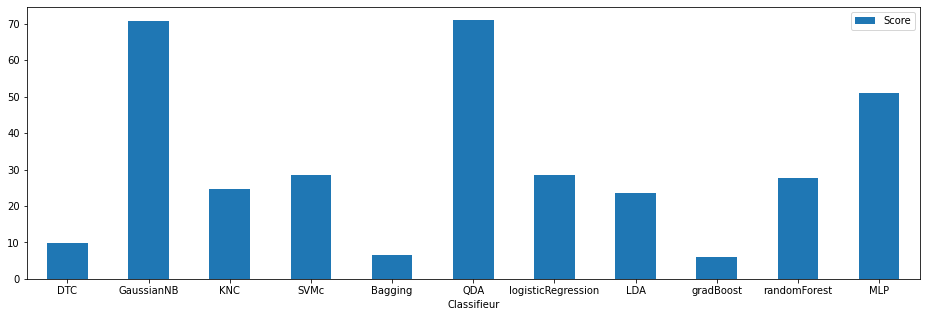

In [85]:
X, y = prepareKDD(dfad)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

#print(y_test)
scores, clfName, scoresMsKDD, scoresMsUNSW = all_classifier_score(X_train, X_test, y_train, y_test)
#score
plotClassifieurBarScoreMissclassified(scores)

                                Pourcentage de vecteurs mal classés pour le dataset KDD 

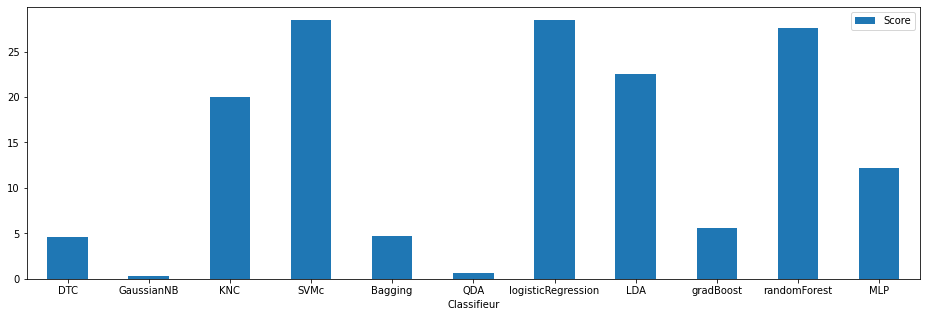

In [86]:
plotClassifieurBarScore(scoresMsKDD)

                                Pourcentage de vecteurs malsains classés en sains pour le dataset KDD

### Génération des données adversial UNSW-NB15

In [87]:
def modify_sample(df, col, val) :
    try :
        mod = df.sample(n=500)
    except :
        mod = df.sample(frac=0.9)
    if (val!=None):
        mod[col] = val
    else :
        mod[col] = mod[col].apply(lambda x :x+randrange(500))
    mod['label'] = 1
    return mod

def twoValSample(df, col) :
    sp1 = modify_sample(df[df[col] == 0], col, 255)
    sp2 = modify_sample(df[df[col] == 255], col, 0)
    return sp1,sp2

def adversial_UNSWNB15(df):
    dfCopy = df.copy()
    #normal state
    dfCopy = dfCopy[dfCopy['label'] == 0]
    frames = [dfCopy]
    
    #perturbations
    stcpb_increase = modify_sample(dfCopy, 'stcpb', 50000)
    frames.append(stcpb_increase)
    dtcpb_increase = modify_sample(dfCopy, 'dtcpb', 50000)
    frames.append(dtcpb_increase)
    swin_reverse1, swin_reverse2 = twoValSample(dfCopy, 'swin')
    frames.append(swin_reverse1)
    frames.append(swin_reverse2)
    dwin_reverse1,dwin_reverse2 = twoValSample(dfCopy, 'dwin')
    frames.append(dwin_reverse1)
    frames.append(dwin_reverse2)
    ackdat_increase = modify_sample(dfCopy, 'ackdat', 0.05)
    frames.append(ackdat_increase)
    sbytes_increase = modify_sample(dfCopy, 'sbytes', 1000)
    frames.append(sbytes_increase)
    dbytes_increase = modify_sample(dfCopy, 'dbytes', 1000)
    frames.append(dbytes_increase)
    spkts_increase = modify_sample(dfCopy, 'spkts', 1000)
    frames.append(spkts_increase)
    dpkts_increase = modify_sample(dfCopy, 'dpkts', 1000)
    frames.append(dpkts_increase)
    ct_dst_src_ltm_increase = modify_sample(dfCopy, 'ct_dst_src_ltm', 6)
    frames.append(ct_dst_src_ltm_increase)
    
    #retrieving final adversarial dataset 
    adversial = pd.concat(frames, ignore_index=True, sort=False)
    adversial = shuffle(adversial)
    adversial.reset_index(inplace=True, drop=True)
    return adversial

In [88]:
dfad2 = adversial_UNSWNB15(df2)

### Appels de tous les classifieurs et récupération des résultats (dataset UNSW_NB15)

c:\users\vasaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\vasaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


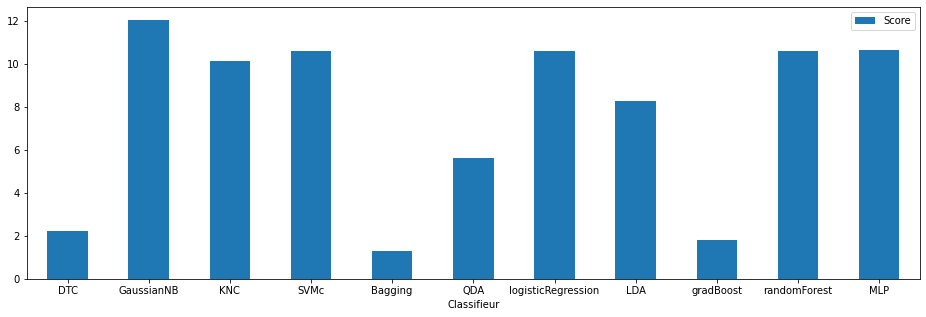

In [89]:
X, y = prepare_UNSW_NB15(dfad2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

scores, clfName, scoresMsKDD, scoresMsUNSW= all_classifier_score(X_train, X_test, y_train, y_test)

plotClassifieurBarScoreMissclassified(scores)

                                Pourcentage de vecteurs mal classés pour le dataset UNSW

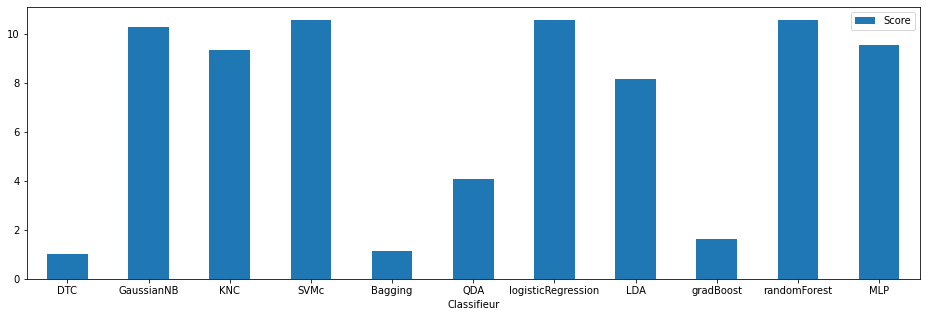

In [90]:
plotClassifieurBarScore(scoresMsUNSW)

                            Pourcentage de vecteurs malsains classés en sains pour le dataset UNSW 